In [1]:
import numpy as np
import pandas as pd
import random as rnd
import torch
from matplotlib import pyplot as plt

import lcpfn.lcpfn as lcpfn

path_test = '/mnt/c/Users/prath/PycharmProjects/rp/LCDB_localised/test_curves.pkl'
df_test = pd.read_pickle(path_test)

path_all = '/mnt/c/Users/prath/PycharmProjects/rp/LCDB_localised/all_curves_preprocessed.pkl'
df_all = pd.read_pickle(path_all)

# model_name = '/mnt/c/Users/prath/PycharmProjects/rp/Data/model_lcdb_2.pt'
model_name = None
if model_name is None:
    model = lcpfn.LCPFN()
else:
    model = lcpfn.LCPFN(model_name=model_name)
print(model_name)

# -------------------------------------------------

path_mmf4_last1 = "/mnt/c/Users/prath/Documents/Uni(Tudelft)/Bsc_cs/Year_3/RP/lcdb/publications/2022-ecml/analysis/"
try:
    df_total = pd.read_pickle(path_mmf4_last1 + "df_total.gz")
except FileNotFoundError:
    df_total = None
    print("df_total not found")


None


In [36]:
#Variables
CUT_OFF = 20 # 10, 20, 40, 80
NO_LAST1 = []
NO_MMF4 = []

In [76]:
def get_curve(i: int):
    """Retrieve the  curve for a given model and dataset."""
    row = df_all.iloc[i]
    opid = row['openmlid']
    lrnr = row['learner']
    anchrs = row['anchors']
    mns = row['means']
    std = row['std']
    return anchrs, mns, std, opid, lrnr

def get_closest_index(lst, target):
    return min(range(len(lst)), key=lambda i: abs(lst[i] - target))

def get_common_data(cutoff, extend, anchors, means, ):
    mns = np.array(means)
    anchrs = np.array(anchors)
    anchrs = ((anchrs - np.min(anchrs)) / (np.max(anchrs) - np.min(anchrs))) * 100

    cutoff_index = get_closest_index(anchrs, cutoff)
    curve = np.array(mns[:cutoff_index])
    anchrs = anchrs.astype(int)

    add_anchor = np.arange(anchrs[-1], extend, 10)
    a = np.concatenate((anchrs, add_anchor))
    x = torch.from_numpy(a).unsqueeze(1)
    y = torch.from_numpy(curve).float().unsqueeze(1)

    return x, y, anchrs, mns, cutoff_index

def get_mse(model, anchors, means, openlid, learner, cutoff=CUT_OFF, extend=100, plot=False):
    x, y, anchrs, mns, cutoff_index = get_common_data(cutoff, extend, anchors, means, )

    predictions = model.predict_quantiles(x_train=x[:cutoff_index], y_train=y, x_test=x[cutoff_index:],
                                          qs=[0.05, 0.5, 0.95])

    if plot:
        plot_it(anchrs, mns, predictions, cutoff_index, x)

    predictions = predictions.detach().numpy()
    mse_lcfpn = np.mean((predictions[:len(anchrs) - cutoff_index, 1] - mns[cutoff_index:]) ** 2)

    return_tup = (mse_lcfpn,)

    if df_total is not None:
        try:
            row = df_total.query(
                f'openmlid == {openlid} & learner == "{learner}" & percentage_bucket == {CUT_OFF / 100} & curve_model == "last1"')
            li = abs(CUT_OFF / 100 - row['percentage'].values)
            index_min = min(range(len(li)), key=li.__getitem__)
            mse_last1 = row.iloc[index_min]['MSE_tst']
        except:
            print("last1 not found")
            print(openlid, learner)
            NO_LAST1.append((openlid, learner))
            print("---------------")
            mse_last1 = None

        try:
            row = df_total.query(
                f'openmlid == {openlid} & learner == "{learner}" & percentage_bucket == {CUT_OFF / 100} & curve_model == "mmf4"')
            li = abs(CUT_OFF / 100 - row['percentage'].values)
            index_min = min(range(len(li)), key=li.__getitem__)
            mse_mmf4 = row.iloc[index_min]['MSE_tst']
        except:
            print("mmf4 not found")
            print(openlid, learner)
            NO_MMF4.append((openlid, learner))
            print("---------------")
            mse_mmf4 = None

        return_tup = (mse_lcfpn, mse_last1, mse_mmf4)
    return return_tup

def get_mae(model, anchors, means, cutoff=CUT_OFF, extend=100, plot=False):
    x, y, anchors, means, cutoff_index = get_common_data(cutoff, extend, anchors, means, )

    predictions = model.predict_quantiles(x_train=x[:cutoff_index], y_train=y, x_test=x[cutoff_index:],
                                          qs=[0.05, 0.5, 0.95])

    if plot:
        plot_it(anchors, means, predictions, cutoff_index, x)

    predictions = predictions.detach().numpy()
    return np.mean(np.abs(predictions[:len(anchors) - cutoff_index, 1] - means[cutoff_index:]))

def plot_it(anchors, means, predictions, cutoff_index, x):
    plt.plot(anchors, means, "*", label="target")
    plt.plot(anchors, means, label="target")
    plt.plot(x[cutoff_index:], predictions[:, 1], "r*", label="Extrapolation by PFN")
    plt.fill_between(
        x[cutoff_index:].flatten(), predictions[:, 0], predictions[:, 2], color="blue", alpha=0.2, label="CI of 90%"
    )
    plt.vlines(x[cutoff_index], 0, 1, linewidth=0.5, color="k", label="cutoff")
    plt.ylim(0, 1)
    plt.legend(loc="lower right")
    plt.savefig("/mnt/c/Users/prath/PycharmProjects/rp/Data/extrapolation.png")
    plt.show()

41144 SVC_linear


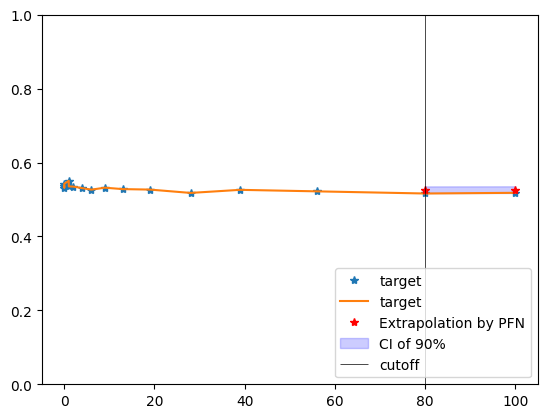

(8.966756396234076e-05, 2.4770719999654497e-05, 8.982104913969501e-06)


In [77]:
anchors, means, std, openlid, learner = get_curve(rnd.randint(0, len(df_all)))
print(openlid, learner)
print(get_mse(model, anchors, means, openlid, learner, cutoff=CUT_OFF, plot=True))

In [78]:
performance = []
performance_lable = []

for i in range(len(df_all)):
    anchors, means, std, openlid, learner = get_curve(i)
    print(i + 1, end='\r')
    performance.append(get_mse(model, anchors, means, openlid, learner))
    performance_lable.append((openlid, learner))
performance = np.array(performance)

last1 not found
41166 sklearn.naive_bayes.MultinomialNB
---------------
mmf4 not found
41166 sklearn.naive_bayes.MultinomialNB
---------------
last1 not found
380 SVC_linear
---------------
mmf4 not found
380 SVC_linear
---------------
last1 not found
380 SVC_poly
---------------
mmf4 not found
380 SVC_poly
---------------
last1 not found
380 SVC_rbf
---------------
mmf4 not found
380 SVC_rbf
---------------
last1 not found
380 SVC_sigmoid
---------------
mmf4 not found
380 SVC_sigmoid
---------------
last1 not found
380 sklearn.discriminant_analysis.LinearDiscriminantAnalysis
---------------
mmf4 not found
380 sklearn.discriminant_analysis.LinearDiscriminantAnalysis
---------------
last1 not found
380 sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
---------------
mmf4 not found
380 sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
---------------
last1 not found
380 sklearn.ensemble.ExtraTreesClassifier
---------------
mmf4 not found
380 sklearn.ensemble.ExtraTr

In [79]:
# Print the results in a clear format
if performance[1].shape[0] == 3:
    df = pd.DataFrame(performance, columns=['mse_lcpfn', 'mse_last1', 'mse_mmf4'], index=performance_lable)
else:
    df = pd.DataFrame(performance, columns=['mse_lcpfn'], index=performance_lable)

In [80]:
df.to_pickle(f'/mnt/c/Users/prath/PycharmProjects/rp/Data/df_mse_{CUT_OFF}.pkl')
df_last1 = pd.DataFrame(NO_LAST1, columns=['openmlid', 'learner'])
df_mmf4 = pd.DataFrame(NO_MMF4, columns=['openmlid', 'learner'])

counts_last1 = df_last1['openmlid'].value_counts()
counts_mmf4 = df_mmf4['openmlid'].value_counts()

counts_last1.to_pickle(f'/mnt/c/Users/prath/PycharmProjects/rp/Data/counts_last1_{CUT_OFF}.pkl')
counts_mmf4.to_pickle(f'/mnt/c/Users/prath/PycharmProjects/rp/Data/counts_mmf4_{CUT_OFF}.pkl')

df_last1.to_pickle(f'/mnt/c/Users/prath/PycharmProjects/rp/Data/df_last1_{CUT_OFF}.pkl')
df_mmf4.to_pickle(f'/mnt/c/Users/prath/PycharmProjects/rp/Data/df_mmf4_{CUT_OFF}.pkl')

[(41166, 'sklearn.naive_bayes.MultinomialNB'), (380, 'SVC_linear'), (380, 'SVC_poly'), (380, 'SVC_rbf'), (380, 'SVC_sigmoid'), (380, 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'), (380, 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis'), (380, 'sklearn.ensemble.ExtraTreesClassifier'), (380, 'sklearn.ensemble.GradientBoostingClassifier'), (380, 'sklearn.ensemble.RandomForestClassifier'), (380, 'sklearn.linear_model.LogisticRegression'), (380, 'sklearn.linear_model.PassiveAggressiveClassifier'), (380, 'sklearn.linear_model.Perceptron'), (380, 'sklearn.linear_model.RidgeClassifier'), (380, 'sklearn.linear_model.SGDClassifier'), (380, 'sklearn.naive_bayes.BernoulliNB'), (380, 'sklearn.naive_bayes.MultinomialNB'), (380, 'sklearn.neighbors.KNeighborsClassifier'), (380, 'sklearn.neural_network.MLPClassifier'), (380, 'sklearn.tree.DecisionTreeClassifier'), (380, 'sklearn.tree.ExtraTreeClassifier'), (346, 'SVC_linear'), (346, 'SVC_poly'), (346, 'SVC_rbf'), (346, 'SVC_s

0.28717668655646394
0.9984570991846216
0.36320072588054275


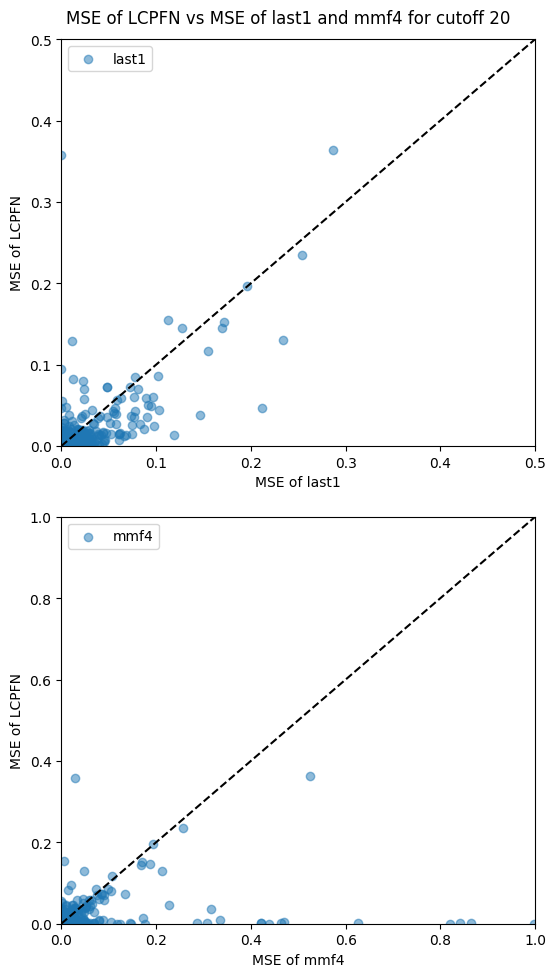

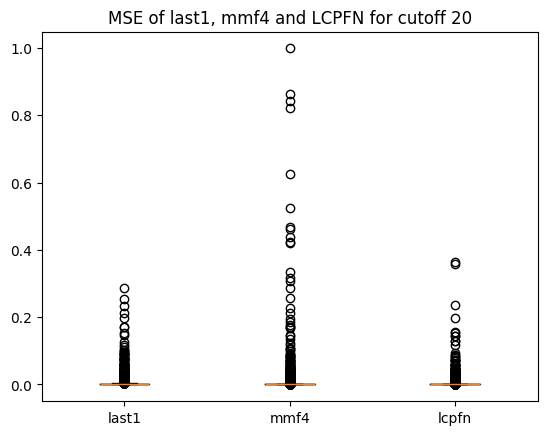

In [37]:
df = pd.read_pickle(f'/mnt/c/Users/prath/PycharmProjects/rp/Data/df_mse_{CUT_OFF}.pkl')
#plot the results

#remove none values and remove outliers
df = df[df['mse_last1'].notna()]
df = df[df['mse_mmf4'].notna()]
df = df[df['mse_last1'] < 1]
df = df[df['mse_mmf4'] < 1]
df = df[df['mse_lcpfn'] < 1]

print(max(df['mse_last1']))
print(max(df['mse_mmf4']))
print(max(df['mse_lcpfn']))

fig,ax = plt.subplots(nrows=2, figsize=(6, 10))
# fig.tight_layout()
fig.tight_layout(pad=3.0)
fig.subplots_adjust(top=0.95)

ax[0].scatter(df['mse_last1'], df['mse_lcpfn'], label='last1', alpha=0.5)
x = np.linspace(0, 1, 100)
ax[0].plot(x, x, color='black', linestyle='--')
ax[0].set_xlabel('MSE of last1')
ax[0].set_ylabel('MSE of LCPFN')
ax[0].legend()
ax[0].set_ylim(0, 0.5)
ax[0].set_xlim(0, 0.5)

ax[1].scatter(df['mse_mmf4'], df['mse_lcpfn'], label='mmf4', alpha=0.5)
x = np.linspace(0, 1, 100)
ax[1].plot(x, x, color='black', linestyle='--')
ax[1].set_xlabel('MSE of mmf4')
ax[1].set_ylabel('MSE of LCPFN')
ax[1].legend()
ax[1].set_ylim(0, 1)
ax[1].set_xlim(0, 1)

fig.suptitle(f'MSE of LCPFN vs MSE of last1 and mmf4 for cutoff {CUT_OFF}')
plt.savefig(f'/mnt/c/Users/prath/PycharmProjects/rp/Data/mse_{CUT_OFF}.png')
plt.show()



plt.boxplot([df['mse_last1'], df['mse_mmf4'], df['mse_lcpfn']], labels=['last1', 'mmf4', 'lcpfn'])
plt.title(f'MSE of last1, mmf4 and LCPFN for cutoff {CUT_OFF}')
plt.savefig(f'/mnt/c/Users/prath/PycharmProjects/rp/Data/mse_box_plot_{CUT_OFF}.png')
plt.show()